### PSO

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def potential(shape, x, x0, h, theta):
    if shape == 'sphere':
        return 100 * ((x - x0) * np.cos(np.radians(theta)) - h * np.sin(np.radians(theta))) / ((x - x0) ** 2 + h ** 2) ** (0.5)
    elif shape == 'cylinder':
        return 100 * ((x - x0) * np.cos(np.radians(theta)) - h * np.sin(np.radians(theta))) / ((x - x0) ** 2 + h ** 2)
    else:
        raise ValueError("Shape must be 'sphere' or 'cylinder'.")

def calc_error(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

def pso_optimization(shape, x0_true, h_true, theta_true, num_particles=50, max_iter=1000):
    
    # Generate synthetic data
    x = np.array([0,10,20,30,40,50,60,70,80,90,100])
    #actual_values = potential(shape, x, x0_true, h_true, theta_true)
    actual_values = np.array([-9,-10,-11,-12,-14,-16,-18,-19,-22,-24,-25,-24,-23,-20,-18,-16,-14,-12,-11,-10,-9])
    # Initialize PSO parameters
    pos = np.random.rand(num_particles, 3)
    pos[:, 0] = pos[:, 0] * 100 - 100 
    pos[:, 1] = pos[:, 1] * 45 + 5    
    pos[:, 2] = pos[:, 2] * 90         
    vel = np.zeros((num_particles, 3))
    l_best = pos.copy()
    g_best = pos[0]

    errors = []
    
    for iter in range(max_iter):
        V = np.array([potential(shape, x, p[0], p[1], p[2]) for p in pos]).T
        G = potential(shape, x, g_best[0], g_best[1], g_best[2])

        # Update local best
        for i in range(num_particles):
            if calc_error(V[:, i], actual_values) < calc_error(potential(shape, x, l_best[i, 0], l_best[i, 1], l_best[i, 2]), actual_values):
                l_best[i] = pos[i]

        # Update global best
        min_error_idx = np.argmin([calc_error(V[:, i], actual_values) for i in range(num_particles)])
        if calc_error(V[:, min_error_idx], actual_values) < calc_error(G, actual_values):
            g_best = pos[min_error_idx]
        # Update velocities and positions
        for j in range(num_particles):
            r1, r2 = np.random.rand(2)
            vel[j] = 0.1 * vel[j] + 2 * r1 * (l_best[j] - pos[j]) + 2 * r2 * (g_best - pos[j])
            pos[j] += vel[j]

            # Clipping positions
            pos[j][0] = np.clip(pos[j][0],0, 100)  
            pos[j][1] = np.clip(pos[j][1], 5, 50)      
            pos[j][2] = np.clip(pos[j][2], 0, 90)      

        current_error = calc_error(G, actual_values)
        errors.append(current_error)

        if current_error < 0.001:
            break

    return g_best, current_error, errors

# Parameters
x0_true = 25
h_true = 10
theta_true = 90
shape = 'sphere'


final_params, final_error, error_history = pso_optimization(shape, x0_true, h_true, theta_true)

# Output results
print(f'Original parameters: x = {x0_true}, h = {h_true}, theta = {theta_true}')
print(f'Final parameters: x = {final_params[0]}, h = {final_params[1]}, theta = {final_params[2]}')
print(f'Final Error: {final_error}')

# Plotting the error
plt.figure()
plt.plot(error_history, label='Error over Iterations', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error vs Number of Iterations')
plt.legend()
plt.grid()
plt.savefig('Error.png', dpi=300)
plt.show()

# Generate final predicted values
x = np.arange(-100, 100)
final_pred = potential(shape, x, final_params[0], final_params[1], final_params[2])

# Plotting actual vs predicted profile
actual_values = potential(shape, x, x0_true, h_true, theta_true)
plt.figure()
plt.plot(x, actual_values * 1000, label='Actual', color='red')
plt.plot(x, final_pred * 1000, label='PSO Prediction', color='blue', linestyle='dashed')
plt.title('Potential Profile')
plt.xlabel('x')
plt.ylabel('V (mV)')
plt.legend()
plt.grid()
plt.show()
np.random.seed(42)

ValueError: operands could not be broadcast together with shapes (11,) (21,) 

### PSO (with Analytical Signal)

Total iterations: 21
Original params: x = 45, h = 15
Final params: x = 45.0000, h = 15.0000
Final Error: 0.0000


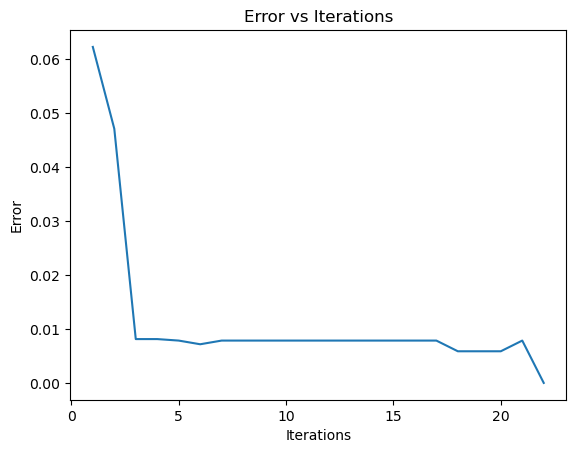

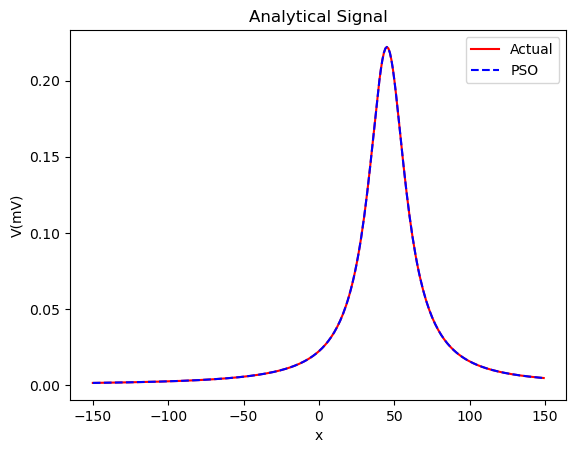

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def AnalyticalSignal(X, Xo, h,shape='sphere'):
    if(shape=='sphere'):
        return 50 / ((X - Xo) ** 2 + h ** 2)
    elif(shape=='cylinder'):
       return 50 / ((X - Xo) ** 2 + h ** 2)**1.5 

x = np.arange(-150, 150)
Xo, h = 45,15
signal_actual = AnalyticalSignal(x, Xo, h)

def Error(pred):
    return np.sqrt(np.mean((pred - signal_actual[:, np.newaxis]) ** 2, axis=0))

runs = 0

while True:
    iter_counts = []
    errors_g = []
    runs += 1
    pos = np.random.rand(2, 20) * np.array([[300], [45]]) - np.array([[150], [5]])
    l_best = pos.copy()
    signal = np.empty((300, 20))
    L = np.empty((300, 20))
    G = np.empty((300, 1))
    U = np.zeros((2, 20))
    g_best = np.full((2, 1), 500)
    iter_count = 0

    while True:
        iter_count += 1

        for k in range(20):
            signal[:, k] = AnalyticalSignal(x, pos[0, k], pos[1, k])
            L[:, k] = AnalyticalSignal(x, l_best[0, k], l_best[1, k])
        G[:, 0] = AnalyticalSignal(x, g_best[0, 0], g_best[1, 0])

        for i in range(20):
            if Error(signal[:, i:i+1]) <= Error(L[:, i:i+1]):
                l_best[:, i] = pos[:, i]

        min_error_idx = np.argmin(Error(signal), axis=0)
        if Error(signal).min() < Error(G).min():
            g_best[:, 0] = pos[:, min_error_idx]

        r1, r2 = np.random.rand(2)
        U = 0.1 * U - 2 * r1 * (pos - l_best) - 2 * r2 * (pos - g_best)

        pos += U
        pos = np.clip(pos, [[-150], [5]], [[150], [50]])

        iter_counts.append(iter_count)
        errors_g.append(Error(G).min())

        if Error(G).min() < 0.001:
            break
            
    if iter_count:
        break

print(f'Total iterations: {(runs - 1) * 400 + iter_count - 1}')
print(f'Original params: x = {Xo}, h = {h}')
print(f'Final params: x = {g_best[0, 0]:.4f}, h = {g_best[1, 0]:.4f}')
print(f'Final Error: {Error(G).min():.4f}')

plt.plot(iter_counts, errors_g)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error vs Iterations')
plt.savefig('Error.png', dpi=300)
plt.show()

signal_pred = AnalyticalSignal(x, g_best[0, 0], g_best[1, 0],'sphere')
plt.plot(x, signal_actual, label='Actual', color='red')
plt.plot(x, signal_pred, label='PSO', color='blue', linestyle='dashed')
plt.title('Analytical Signal')
plt.xlabel('x')
plt.ylabel('V(mV)')
plt.legend()
plt.show()
np.random.seed(42)